# 1. Introduction et Contextualisation

### Présentation du problème et objectifs du projet

Au cœur du succès d'une entreprise se trouve son processus de recrutement, un défi complexe où il est crucial d'assurer une sélection de candidats exempte de biais. En effet, les préjugés dans le recrutement, souvent inconscients, peuvent limiter la diversité et perpétuer des inégalités, fermant la porte à des talents prometteurs. Un recrutement biaisé réduit la diversité de pensée, essentielle à l'innovation et à la créativité.

Notre projet vise à créer une solution de recrutement qui respecte et valorise la diversité, tout en fournissant aux entreprises les moyens de recruter des talents de manière juste et efficace. L'objectif est de développer un outil de sélection de candidats innovant, qui identifie les biais dans le processus de recrutement et les atténue.

L'objectif est donc double. Grâce à des analyses approfondies, notre solution vise d'abord à mettre en lumière les biais existants dans les pratiques de recrutement actuelles. Dans un second temps, notre système offre des insights précieux sur la manière de structurer des processus de recrutement plus inclusifs, et propose des méthodes pour évaluer les candidats de manière plus équitable.

### Aspect technique

##### Packages

In [ ]:
!pip install openpyxl
!pip install dalex
!pip install statsmodels
!pip install wordcloud
!pip install xgboost
!pip install xlrd

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
#import seaborn as sns
#from statsmodels.graphics.mosaicplot import mosaic
from wordcloud import WordCloud

from collections import Counter

import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
from IPython.display import HTML #pour afficher les graphes dans une cellule de notebook

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
import dalex as dx
from copy import copy
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
import requests
from io import StringIO

# 2. Collecte et Nettoyage des Données

### Application Streamlit

Les données que nous avons utilisées sont présentées dans une application développée via Streamlit. Celle-ci présente la distribution des variables d'intérêt et facilite la navigation entre les différents graphiques. Elle présente aussi de façon interactive les modèles réalisés. 

**Nous vous invitons à consulter cette application** (le contenu de ses pages est toutefois reporté dans les sections 4 et 5 de ce notebook).

*Étapes pour lancer l'application* : 
- ouvrir un terminal,
- se placer dans le dossier 'Projet-Python-ENSAE' (qui contient le script de lancement de l'application 'Accueil.py' et le dossier 'pages' contenant les scripts des pages,
- exécuter la commande suivante : streamlit run Accueil.py --server.port 5000 --server.address 0.0.0.0

**Attention** : si vous consultez ce Notebook dans un environnement Jupyter via le SSP Cloud, il est nécessaire d'avoir ouvert au préalable un *custom service port* au lancement du service Jupyter. Vous pouvez le faire dans la 'Configuration Jupyter-Python', onglet 'Networking' : cochez 'Enable a custom service port'. Par défaut, le port est 5000. Attention à bien spécifier le même port dans la commande ci-dessus. 

### Identification et acquisition de données pertinentes

La réussite de notre projet repose sur une base de données robuste et fiable. Cette étape cruciale détermine la qualité et l'efficacité de toute notre analyse ultérieure. 

**Identification des Sources de Données :** Notre quête commence par la recherche de bases de données existantes qui fournissent des informations complètes et fiables sur les candidats, les processus de recrutement et les critères de sélection. 

L'enquête annuelle générée par les utilisateurs de StackOverflow (plus de 70 000 réponses de plus de 180 pays) examine tous les aspects de l'expérience des développeurs, de l'apprentissage du code aux technologies préférées, en passant par le contrôle de version et l'expérience professionnelle. C'est une enquête très complète et riche. On choisit donc ici de s'appuyer sur l'édition 2022 de l'enquête, qui contient les réponses de 73462 développeurs.

À partir des résultats de l'enquête, nous avons construit un jeu de données avec les colonnes suivantes :
- **Age** : âge du candidat, >35 ans ou <35 ans *(catégorique)*
- **EdLevel** : niveau d'éducation du candidat (Licence, Master, Doctorat...) *(catégorique)*
- **Gender** : genre du candidat, (Homme, Femme, ou Non-Binaire) *(catégorique)*
- **MainBranch** : si le candidat est un développeur professionnel *(catégorique)*
- **YearsCode** : depuis combien de temps le candidat programme *(entier)*
- **YearsCodePro** : depuis combien de temps le candidat programme dans un contexte professionnel *(entier)*
- **PreviousSalary** : salaire du dernier emploi du candidat *(flottant)*
- **ComputerSkills** : nombre de compétences informatiques connues par le candidat *(entier)*
- **Employed** : variable cible, indiquant si le candidat a été embauché *(catégorique)*


In [28]:
# Premiere base de donnees sur les developpeurs

df = pd.read_csv("stackoverflow_full.csv", index_col="Unnamed: 0")

df.head(10)

Age Accessibility        EdLevel  Employment Gender MentalHealth  \
0  <35            No         Master           1    Man           No   
1  <35            No  Undergraduate           1    Man           No   
2  <35            No         Master           1    Man           No   
3  <35            No  Undergraduate           1    Man           No   
4  >35            No            PhD           0    Man           No   
5  <35            No         Master           1    Man           No   
6  >35            No         Master           1    Man           No   
7  <35            No         Master           1    Man           No   
8  >35            No  Undergraduate           1    Man           No   
9  >35            No         Master           1    Man           No   

  MainBranch  YearsCode  YearsCodePro  \
0        Dev          7             4   
1        Dev         12             5   
2        Dev         15             6   
3        Dev          9             6   
4     NotDev         40            30   
5        Dev          9             2   
6        Dev         26            18   
7     NotDev         14             5   
8        Dev         39            21   
9        Dev         20            16   

                                             Country  PreviousSalary  \
0                                             Sweden         51552.0   
1                                              Spain         46482.0   
2                                            Germany         77290.0   
3                                             Canada         46135.0   
4                                          Singapore        160932.0   
5                                             France         38915.0   
6                                            Germany         77831.0   
7                                        Switzerland         81319.0   
8  United Kingdom of Great Britain and Northern I...         68507.0   
9                                 Russian Federation         37752.0   

                                      HaveWorkedWith  ComputerSkills  Employed  
0                          C++;Python;Git;PostgreSQL               4         0  
1  Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...              12         1  
2             C;C++;Java;Perl;Ruby;Git;Ruby on Rails               7         0  
3  Bash/Shell;HTML/CSS;JavaScript;PHP;Ruby;SQL;Gi...              13         0  
4                                         C++;Python               2         0  
5                 JavaScript;Python;Docker;Git;MySQL               5         0  
6  C++;HTML/CSS;Java;JavaScript;Kotlin;Node.js;Ty...              17         1  
7                              C++;Python;Docker;Git               4         0  
8                              Python;Git;PostgreSQL               3         0  
9              Delphi;Java;SQL;Docker;Git;PostgreSQL               6         0

**PROPOSITION D'EVOLUTION**

**Acquisition de Données :** L'enquête sur laquelle on construit notre analyse est riche et permet de construire une base de bonne qualité. C'est pour cette raison qu'elle est au centre de notre projet. Néanmoins, il s'agit d'une enquête très sectorisée, qui s'adresse uniquement aux utilisateurs de StackOverFlow. Nous n'avons pu trouver d'autres bases accessibles publiquement qui contiendraient des données plus générales sur les individus et l'emploi. Un prolongement de ce projet pourrait donc être d'essayer nos algorithmes sur d'autres bases, s'intéressant notamment à d'autres secteurs d'activité. 

### Nettoyage et prétraitement des données

**Valeurs manquantes :** On commence par traiter les valeurs manquantes et s'assurer que les données sont structurées de manière à faciliter les analyses ultérieures.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73462 entries, 0 to 73461
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             73462 non-null  object 
 1   Accessibility   73462 non-null  object 
 2   EdLevel         73462 non-null  object 
 3   Employment      73462 non-null  int64  
 4   Gender          73462 non-null  object 
 5   MentalHealth    73462 non-null  object 
 6   MainBranch      73462 non-null  object 
 7   YearsCode       73462 non-null  int64  
 8   YearsCodePro    73462 non-null  int64  
 9   Country         73462 non-null  object 
 10  PreviousSalary  73462 non-null  float64
 11  HaveWorkedWith  73399 non-null  object 
 12  ComputerSkills  73462 non-null  int64  
 13  Employed        73462 non-null  int64  
dtypes: float64(1), int64(5), object(8)
memory usage: 8.4+ MB


L'enquête ne contient donc pas de valeurs manquantes, sauf pour la variable `HaveWorkedWith`qui contient les langages maîtrisés par les répondants. Cette variable n'est pas disponible pour 63 des 73462 répondants. 

**Recodage des variables catégorielles : traduction des labels (de l'anglais vers le français)**

In [30]:
# Recodage des variables catégorielles (ENG -> FR)

df_fr = df.copy()

df_fr["EmployedCat"] = pd.cut(df_fr["Employed"], bins=[-1, 0, 1], labels=["Sans emploi", "En emploi"])

df_fr["Age"] = df_fr["Age"].replace(
    ["<35", ">35"],
    ["Moins de 35 ans", "Plus de 35 ans"]
)

df_fr["Accessibility"] = df_fr["Accessibility"].replace(
    ["No", "Yes"],
    ["Non", "Oui"]
)

df_fr["EdLevel"] = df_fr["EdLevel"].replace(
    ["NoHigherEd", "Undergraduate", "Master", "PhD", "Other"],
    ["Pas d'éducation supérieure", "Licence", "Master", "Doctorat", "Autre"]
)

df_fr["Gender"] = df_fr["Gender"].replace(
    ["Man", "Woman", "NonBinary"],
    ["Homme", "Femme", "Non-Binaire"]
)

df_fr["MentalHealth"] = df_fr["MentalHealth"].replace(
    ["No", "Yes"],
    ["Non", "Oui"]
)

df_fr["MainBranch"] = df_fr["MainBranch"].replace(
    ["Dev", "NotDev"],
    ["Développement", "Autre"]
)


In [31]:
df_fr.head()

Age Accessibility   EdLevel  Employment Gender MentalHealth  \
0  Moins de 35 ans           Non    Master           1  Homme          Non   
1  Moins de 35 ans           Non   Licence           1  Homme          Non   
2  Moins de 35 ans           Non    Master           1  Homme          Non   
3  Moins de 35 ans           Non   Licence           1  Homme          Non   
4   Plus de 35 ans           Non  Doctorat           0  Homme          Non   

      MainBranch  YearsCode  YearsCodePro    Country  PreviousSalary  \
0  Développement          7             4     Sweden         51552.0   
1  Développement         12             5      Spain         46482.0   
2  Développement         15             6    Germany         77290.0   
3  Développement          9             6     Canada         46135.0   
4          Autre         40            30  Singapore        160932.0   

                                      HaveWorkedWith  ComputerSkills  \
0                          C++;Python;Git;PostgreSQL               4   
1  Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...              12   
2             C;C++;Java;Perl;Ruby;Git;Ruby on Rails               7   
3  Bash/Shell;HTML/CSS;JavaScript;PHP;Ruby;SQL;Gi...              13   
4                                         C++;Python               2   

   Employed  EmployedCat  
0         0  Sans emploi  
1         1    En emploi  
2         0  Sans emploi  
3         0  Sans emploi  
4         0  Sans emploi

**Variables catégorielles et variables numériques :**

In [32]:
cat=["Age","Accessibility","EdLevel","Gender","MentalHealth","MainBranch"]
num=["YearsCode","YearsCodePro","PreviousSalary","ComputerSkills"]

# 3. Enrichissement des données : informations sur les pays

Dans cette section, on enrichit notre base par plusieurs variables disponibles sur les pays des répondants. En effet, un des intérêts de l'enquête exploitée est son aspect international. Nous souhaitons donc étuder les différences entre pays dans les données collectées.

### Ajout d'une colonne "Code ISO" (nécessaire pour les cartes)

Tout d'abord, le Code ISO des pays est nécessaire pour pouvoir tracer des cartes (dans la suite de l'analyse, cf partie 4). On récupère ce code par le scrapping du site officiel des codes ISO : https://www.iban.com/country-codes. 

In [33]:
# Scrapping des codes ISO des pays

from bs4 import BeautifulSoup
import requests

url = "https://www.iban.com/country-codes"

page = requests.get(url)

soup = BeautifulSoup(page.text, 'html')

table = soup.find('table')

titles = table.find_all('th')

table_titles = [title.text for title in titles]

iso = pd.DataFrame(columns = table_titles)

column_data = table.find_all('tr')

for row in column_data[1:]:
    row_data = row.find_all('td')
    individual_row_data = [data.text for data in row_data]
    length = len(iso)
    iso.loc[length] = individual_row_data

print(iso)

               Country Alpha-2 code Alpha-3 code Numeric
0          Afghanistan           AF          AFG     004
1        Åland Islands           AX          ALA     248
2              Albania           AL          ALB     008
3              Algeria           DZ          DZA     012
4       American Samoa           AS          ASM     016
..                 ...          ...          ...     ...
244  Wallis and Futuna           WF          WLF     876
245     Western Sahara           EH          ESH     732
246              Yemen           YE          YEM     887
247             Zambia           ZM          ZMB     894
248           Zimbabwe           ZW          ZWE     716

[249 rows x 4 columns]


In [34]:
# Conversion en dictionnaire
iso_dict = iso.set_index('Country')['Alpha-3 code'].to_dict()

# Ajout des valeurs manquantes
dict_missing_values = {'United Kingdom of Great Britain and Northern Ireland' : 'GBR',
                       'Russian Federation' : 'RUS',
                       'United States of America' : 'USA',
                       'Netherlands' : 'NLD',
                       'Iran, Islamic Republic of...' : 'IRN',
                       'Hong Kong (S.A.R.)' : 'HKG',
                       'United Arab Emirates' : 'ARE',
                       'Bolivia' : 'BOL',
                       'Czech Republic' : 'CZE',
                       'The former Yugoslav Republic of Macedonia' : 'MKD',
                       'Venezuela, Bolivarian Republic of...' : 'VEN',
                       'Dominican Republic' : 'DOM',
                       'Syrian Arab Republic' : 'SYR',
                       'Taiwan' : 'TWN',
                       'South Korea' : 'KOR',
                       'Republic of Moldova' : 'MDA',
                       "Lao People's Democratic Republic" : 'LAO',
                       'Democratic Republic of the Congo' : 'COG',
                       'Philippines' : 'PHL',
                       'United Republic of Tanzania' : 'TZA',
                       'Kosovo' : 'XXK',
                       'Nomadic' : None,
                       'Congo, Republic of the...' : 'COG',
                       'Republic of Korea' : 'KOR',
                       'Swaziland' : 'SWZ',
                       'Libyan Arab Jamahiriya' : 'LBY',
                       'Sudan' : 'SDN',
                       'Palestine' : 'PSE',
                       'Cape Verde' : 'CPV',
                       'Niger' : 'NER',
                       'Gambia' : 'GMB'
                      }

iso_dict.update(dict_missing_values)

#print(iso_dict)

# Ajout de la colonne
df_fr['ISO'] = df_fr['Country'].map(iso_dict)
#df_fr.head(10)

In [35]:
# Traitement des données manquantes : 

# Nombre de valeurs manquantes de ISO
none_count_iso = df_fr['ISO'].isnull().sum()

# Valeurs de Country correspondant aux ISO manquants
none_indices_iso = df_fr.index[df_fr['ISO'].isnull()].tolist()
values_at_indices_iso = df_fr['Country'].iloc[none_indices_iso]

print("Le nombre de valeurs manquantes est : ", none_count_iso)
print("Les valeurs des pays correspondants sont : \n", values_at_indices_iso.drop_duplicates())

Le nombre de valeurs manquantes est :  25
Les valeurs des pays correspondants sont : 
 3503    Nomadic
Name: Country, dtype: object


### Ajout d'une colonne "Continent"

In [36]:
# Chargement du tableau contenant les continents des pays
cont_pays = pd.read_excel("Countries_Languages.xls", skiprows = 1)

cont_pays.head()

Continental Region      Country  Population (million) (2005 UN estimates)  \
0        Asia (West)  Afghanistan                                    29.863   
1             Europe      Albania                                     3.130   
2             Africa      Algeria                                    32.854   
3             Europe      Andorra                                     0.067   
4             Africa       Angola                                    15.941   

  No. of native spoken languages  \
0                             47   
1                            <10   
2                             18   
3                            <10   
4                             41   

  Main Spoken Languages,Language Groups (with estimated % of first language speakers if over 10% of population)  \
0            Pashto (28%), Dari Persian (20%), Uzbek                                                              
1                 Albanian (Tosk, Gheg) (90%), Greek                                                              
2  Maghrebi Arabic (64%), Berber,Tamazight langua...                                                              
3               Catalan (44%), Spanish (35%), French                                                              
4  Umbundu (36%), Kimbundu (27%), Kikongo, Chokwe...                                                              

  Languages with official status  \
0           Dari Persian, Pashto   
1        Albanian (Tosk dialect)   
2                         Arabic   
3                        Catalan   
4                     Portuguese   

          Languages with national or regional status  
0  Arabic, Balochi, Nuristani, Pamiri, Pashai, Tu...  
1                                                NaN  
2                                          Tamazight  
3                                                NaN  
4                Kikongo, Kimbundu, Chokwe, Kwanyama

In [37]:
# Conversion en dictionnaire
continents_dict = cont_pays.set_index('Country')['Continental Region'].to_dict()

# Ajout des valeurs manquantes
dict_missing_values = {'United Kingdom of Great Britain and Northern Ireland' : 'Europe',
                       'Russian Federation' : 'Europe',
                       'United States of America' : 'North,Central America',
                       'Viet Nam' : 'Asia (West)',
                       'Iran, Islamic Republic of...' : 'Asia (West)',
                       'Hong Kong (S.A.R.)' : 'Asia (East)',
                       'Belarus' : 'Europe',
                       'The former Yugoslav Republic of Macedonia' : 'Europe',
                       'Venezuela, Bolivarian Republic of...' : 'South America',
                       'Syrian Arab Republic' : 'Asia (West)',
                       'Taiwan' : 'Asia (East)',
                       'South Korea' : 'Asia (East)',
                       'Cameroon' : 'Africa',
                       'Republic of Moldova' : 'Europe',
                       "Lao People's Democratic Republic" : 'Asia (East)',
                       'Democratic Republic of the Congo' : 'Africa',
                       'United Republic of Tanzania' : 'Africa',
                       'Kosovo' : 'Europe',
                       'Nomadic' : 'Nomadic',
                       'Congo, Republic of the...' : 'Africa',
                       'Republic of Korea' : 'Asia (East)',
                       'Saint Kitts and Nevis' : 'North,Central America',
                       'Monaco' : 'Europe',
                       'Libyan Arab Jamahiriya' : 'Asia (West)',
                       'Palestine' : 'Asia (West)',
                       'Isle of Man' : 'Europe',
                       "Côte d'Ivoire" : 'Africa',
                       'Senegal' : 'Africa',
                       'Saint Lucia' : 'North,Central America',
                       'Saint Vincent and the Grenadines' : 'North,Central America'
                      }

continents_dict.update(dict_missing_values)

#print(continents_dict)

# Ajout de la colonne
df_fr['Continent'] = df_fr['Country'].map(continents_dict)
# df_fr.head(10)

In [38]:
# Traitement des données manquantes : 

# Nombre de valeurs manquantes de Continent
none_count_cont = df_fr['Continent'].isnull().sum()

# Valeurs de Country correspondant aux Continents manquants
none_indices_cont = df_fr.index[df_fr['Continent'].isnull()].tolist()
values_at_indices_cont = df_fr['Country'].iloc[none_indices_cont]

print("Le nombre de valeurs manquantes est : ", none_count_cont)
print("Les valeurs des pays correspondants sont : \n", values_at_indices_cont.drop_duplicates())

Le nombre de valeurs manquantes est :  0
Les valeurs des pays correspondants sont : 
 Series([], Name: Country, dtype: object)


### Ajout de diverses variables mesurant le niveau de développement des pays

On ajoute ici plusieurs variables mesurant le niveau de développement des pays, à savoir : l'Indice de Développement Humain, l'espérance de vie à la naissance, le nombre d'années d'éducation espérées, le revenu national brut par habitant.

**Indice de Développement Humain :**

In [40]:
# Chargement du tableau contenant les informations supplémentaires sur les pays
infos_pays = pd.read_excel("HDI.xlsx", usecols = [1,2,4,6,10], skiprows = 6, 
                          names = ["Country", "HDI", "Life expectancy at birth", "Expected years of schooling",
                          "Gross national income (GNI) per capita"])

infos_pays.head()

Country    HDI  Life expectancy at birth  \
0             Switzerland  0.962                   83.9872   
1                  Norway  0.961                   83.2339   
2                 Iceland  0.959                   82.6782   
3  Hong Kong. China (SAR)  0.952                   85.4734   
4               Australia  0.951                   84.5265   

   Expected years of schooling  Gross national income (GNI) per capita  
0                    16.500299                             66933.00454  
1                    18.185200                             64660.10622  
2                    19.163059                             55782.04981  
3                    17.278170                             62606.84540  
4                    21.054590                             49238.43335

In [41]:
# Conversion en dictionnaire
hdi_dict = infos_pays.set_index('Country')['HDI'].to_dict()

# Ajout des valeurs manquantes
dict_missing_values = {'United Kingdom of Great Britain and Northern Ireland' : 0.929,
                       'Turkey' : 0.838,
                       'United States of America' : 0.921,
                       'Iran, Islamic Republic of...' : 0.774,
                       'Hong Kong (S.A.R.)' : 0.952,
                       'Bolivia' : 0.692,
                       'Czech Republic' : 0.889,
                       'The former Yugoslav Republic of Macedonia' : 0.77,
                       'Venezuela, Bolivarian Republic of...' : 0.691,
                       'Taiwan' : 0.768,
                       'South Korea' : None,
                       'Republic of Moldova' : 0.767,
                       'Democratic Republic of the Congo' : 0.571,
                       'United Republic of Tanzania' : 0.549,
                       'Kosovo' : None,
                       'Nomadic' : None,
                       'Congo, Republic of the...' : 0.571,
                       'Republic of Korea' : None,
                       'Swaziland' : 0.597,
                       'Libyan Arab Jamahiriya' : 0.718,
                       'Palestine' : 0.715,
                       'Isle of Man' : None,
                       'Cape Verde' : None
                      }

hdi_dict.update(dict_missing_values)

#print(hdi_dict)

# Ajout de la colonne
df_fr['HDI'] = df_fr['Country'].map(hdi_dict)
# df_fr.head(10)

In [42]:
# Traitement des données manquantes : 

# Nombre de valeurs manquantes de HDI
none_count_hdi = df_fr['HDI'].isnull().sum()

# Valeurs de Country correspondant aux HDI manquants
none_indices_hdi = df_fr.index[df_fr['HDI'].isnull()].tolist()
values_at_indices_hdi = df_fr['Country'].iloc[none_indices_hdi]

print("Le nombre de valeurs manquantes est : ", none_count_hdi)
print("Les valeurs des pays correspondants sont : \n", values_at_indices_hdi.drop_duplicates())

Le nombre de valeurs manquantes est :  256
Les valeurs des pays correspondants sont : 
 741            South Korea
1591               Somalia
2347                Kosovo
3503               Nomadic
5089     Republic of Korea
7149                Monaco
11674          Isle of Man
12898           Cape Verde
Name: Country, dtype: object


**Espérance de vie à la naissance :**

In [17]:
# Conversion en dictionnaire
le_dict = infos_pays.set_index('Country')['Life expectancy at birth'].to_dict()

# Ajout des valeurs manquantes
dict_missing_values = {'United Kingdom of Great Britain and Northern Ireland' : 80.7422,
                       'Turkey' : 76.0324,
                       'United States of America' : 77.1982,
                       'Iran, Islamic Republic of...' : 73.8749,
                       'Hong Kong (S.A.R.)' : 85.4734,
                       'Bolivia' : 63.6304,
                       'Czech Republic' : 77.7283,
                       'The former Yugoslav Republic of Macedonia' : 73.8415,
                       'Venezuela, Bolivarian Republic of...' : 70.5536,
                       'Taiwan' : 78.2107,
                       'South Korea' : 73.2845,
                       'Republic of Moldova' : 68.8459,
                       'Democratic Republic of the Congo' : 63.5187,
                       'United Republic of Tanzania' : 66.2007,
                       'Kosovo' : None,
                       'Nomadic' : None,
                       'Congo, Republic of the...' : 63.5187,
                       'Republic of Korea' : 73.2845,
                       'Swaziland' : 57.0657,
                       'Libyan Arab Jamahiriya' : 71.9112,
                       'Palestine' : 73.4727,
                       'Isle of Man' : None,
                       'Cape Verde' : None
                      }

le_dict.update(dict_missing_values)

#print(le_dict)

# Ajout de la colonne
df_fr['LifeExpectancy'] = df_fr['Country'].map(le_dict)
#df_fr.head(10)

In [18]:
# Traitement des données manquantes : 

# Nombre de valeurs manquantes de Life expectancy
none_count_le = df_fr['LifeExpectancy'].isnull().sum()

# Valeurs de Country correspondant aux Life expectancy manquants
none_indices_le = df_fr.index[df_fr['LifeExpectancy'].isnull()].tolist()
values_at_indices_le = df_fr['Country'].iloc[none_indices_le]

print("Le nombre de valeurs manquantes est : ", none_count_le)
print("Les valeurs des pays correspondants sont : \n", values_at_indices_le.drop_duplicates())

Le nombre de valeurs manquantes est :  60
Les valeurs des pays correspondants sont : 
 2347          Kosovo
3503         Nomadic
11674    Isle of Man
12898     Cape Verde
Name: Country, dtype: object


**Années d'éducation espérées :**

In [19]:
# Conversion en dictionnaire
eys_dict = infos_pays.set_index('Country')['Expected years of schooling'].to_dict()

# Ajout des valeurs manquantes
dict_missing_values = {'United Kingdom of Great Britain and Northern Ireland' : 17.30971909,
                       'Turkey' : 18.3382206,
                       'United States of America' : 16.28097916,
                       'Iran, Islamic Republic of...' : 14.61524963,
                       'Hong Kong (S.A.R.)' : 17.27816963,
                       'Bolivia' : 14.94697094,
                       'Czech Republic' : 16.21968079,
                       'The former Yugoslav Republic of Macedonia' : 13.62443234,
                       'Venezuela, Bolivarian Republic of...' : 12.81608,
                       'Taiwan' : 14.2361149,
                       'South Korea' : 10.78317,
                       'Republic of Moldova' : 14.43299961,
                       'Democratic Republic of the Congo' : 12.33081527,
                       'United Republic of Tanzania' : 9.221489906,
                       'Kosovo' : None,
                       'Nomadic' : None,
                       'Congo, Republic of the...' : 12.33081527,
                       'Republic of Korea' : 10.78317,
                       'Swaziland' : 13.74434586,
                       'Libyan Arab Jamahiriya' : 12.85428,
                       'Palestine' : 13.35801029,
                       'Isle of Man' : None,
                       'Cape Verde' : None
                      }

eys_dict.update(dict_missing_values)

#print(eys_dict)

# Ajout de la colonne
df_fr['ExpectedSchooling'] = df_fr['Country'].map(eys_dict)
#df_fr.head(10)

In [20]:
# Traitement des données manquantes : 

# Nombre de valeurs manquantes de Expected Schooling
none_count_eys = df_fr['ExpectedSchooling'].isnull().sum()

# Valeurs de Country correspondant aux Expected Schooling manquants
none_indices_eys = df_fr.index[df_fr['ExpectedSchooling'].isnull()].tolist()
values_at_indices_eys = df_fr['Country'].iloc[none_indices_eys]

print("Le nombre de valeurs manquantes est : ", none_count_eys)
print("Les valeurs des pays correspondants sont : \n", values_at_indices_eys.drop_duplicates())

Le nombre de valeurs manquantes est :  64
Les valeurs des pays correspondants sont : 
 1591         Somalia
2347          Kosovo
3503         Nomadic
7149          Monaco
11674    Isle of Man
12898     Cape Verde
Name: Country, dtype: object


**Revenu national brut par habitant :**

In [21]:
# Conversion en dictionnaire
gnipc_dict = infos_pays.set_index('Country')['Gross national income (GNI) per capita'].to_dict()

# Ajout des valeurs manquantes
dict_missing_values = {'United Kingdom of Great Britain and Northern Ireland' : 45224.76564,
                       'Turkey' : 31032.80106,
                       'United States of America' : 64765.21509,
                       'Iran, Islamic Republic of...' : 13000.7117,
                       'Hong Kong (S.A.R.)' : 62606.8454,
                       'Bolivia' : 8111.190194,
                       'Czech Republic' : 38745.21386,
                       'The former Yugoslav Republic of Macedonia' : 15917.75283,
                       'Venezuela, Bolivarian Republic of...' : 4810.882621,
                       'Taiwan' : 17504.39969,
                       'South Korea' : None,
                       'Republic of Moldova' : 14875.33189,
                       'Democratic Republic of the Congo' : 2889.283521,
                       'United Republic of Tanzania' : 2664.329096,
                       'Kosovo' : None,
                       'Nomadic' : None,
                       'Congo, Republic of the...' : 2889.283521,
                       'Republic of Korea' : None,
                       'Swaziland' : 7678.591873,
                       'Libyan Arab Jamahiriya' : 15335.712,
                       'Palestine' : 6582.899416,
                       'Isle of Man' : None,
                       'Cape Verde' : None
                      }

gnipc_dict.update(dict_missing_values)

#print(gnipc_dict)

# Ajout de la colonne
df_fr['GNIperCapita'] = df_fr['Country'].map(gnipc_dict)
#df_fr.head(10)

In [22]:
# Traitement des données manquantes : 

# Nombre de valeurs manquantes de GNI per capita
none_count_gnipc = df_fr['GNIperCapita'].isnull().sum()

# Valeurs de Country correspondant aux GNI per capita manquants
none_indices_gnipc = df_fr.index[df_fr['GNIperCapita'].isnull()].tolist()
values_at_indices_gnipc = df_fr['Country'].iloc[none_indices_gnipc]

print("Le nombre de valeurs manquantes est : ", none_count_gnipc)
print("Les valeurs des pays correspondants sont : \n", values_at_indices_gnipc.drop_duplicates())

Le nombre de valeurs manquantes est :  253
Les valeurs des pays correspondants sont : 
 741            South Korea
2347                Kosovo
3503               Nomadic
5089     Republic of Korea
7149                Monaco
11674          Isle of Man
12898           Cape Verde
Name: Country, dtype: object


### Affichage de la base enrichie

In [23]:
df_fr.head(10)

Age Accessibility   EdLevel  Employment Gender MentalHealth  \
0  Moins de 35 ans           Non    Master           1  Homme          Non   
1  Moins de 35 ans           Non   Licence           1  Homme          Non   
2  Moins de 35 ans           Non    Master           1  Homme          Non   
3  Moins de 35 ans           Non   Licence           1  Homme          Non   
4   Plus de 35 ans           Non  Doctorat           0  Homme          Non   
5  Moins de 35 ans           Non    Master           1  Homme          Non   
6   Plus de 35 ans           Non    Master           1  Homme          Non   
7  Moins de 35 ans           Non    Master           1  Homme          Non   
8   Plus de 35 ans           Non   Licence           1  Homme          Non   
9   Plus de 35 ans           Non    Master           1  Homme          Non   

      MainBranch  YearsCode  YearsCodePro  \
0  Développement          7             4   
1  Développement         12             5   
2  Développement         15             6   
3  Développement          9             6   
4          Autre         40            30   
5  Développement          9             2   
6  Développement         26            18   
7          Autre         14             5   
8  Développement         39            21   
9  Développement         20            16   

                                             Country  ...  \
0                                             Sweden  ...   
1                                              Spain  ...   
2                                            Germany  ...   
3                                             Canada  ...   
4                                          Singapore  ...   
5                                             France  ...   
6                                            Germany  ...   
7                                        Switzerland  ...   
8  United Kingdom of Great Britain and Northern I...  ...   
9                                 Russian Federation  ...   

                                      HaveWorkedWith ComputerSkills  Employed  \
0                          C++;Python;Git;PostgreSQL              4         0   
1  Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...             12         1   
2             C;C++;Java;Perl;Ruby;Git;Ruby on Rails              7         0   
3  Bash/Shell;HTML/CSS;JavaScript;PHP;Ruby;SQL;Gi...             13         0   
4                                         C++;Python              2         0   
5                 JavaScript;Python;Docker;Git;MySQL              5         0   
6  C++;HTML/CSS;Java;JavaScript;Kotlin;Node.js;Ty...             17         1   
7                              C++;Python;Docker;Git              4         0   
8                              Python;Git;PostgreSQL              3         0   
9              Delphi;Java;SQL;Docker;Git;PostgreSQL              6         0   

   EmployedCat  ISO              Continent    HDI  LifeExpectancy  \
0  Sans emploi  SWE                 Europe  0.947         82.9833   
1    En emploi  ESP                 Europe  0.905         83.0100   
2  Sans emploi  DEU                 Europe  0.942         80.6301   
3  Sans emploi  CAN  North,Central America  0.936         82.6565   
4  Sans emploi  SGP            Asia (East)  0.939         82.7545   
5  Sans emploi  FRA                 Europe  0.903         82.4988   
6    En emploi  DEU                 Europe  0.942         80.6301   
7  Sans emploi  CHE                 Europe  0.962         83.9872   
8  Sans emploi  GBR                 Europe  0.929         80.7422   
9  Sans emploi  RUS                 Europe  0.822         69.4190   

   ExpectedSchooling  GNIperCapita  
0          19.418530   54489.37401  
1          17.916901   38353.60164  
2          17.010139   54534.21682  
3          16.396259   46807.98619  
4          16.524321   90918.64471  
5          15.812070   45937.05273  
6          17.010139   54534.21682  
7          16.500299   66933.00454  
8  

# 4. Analyse Exploratoire des Données

*Pour rappel, cette section est consultable sous un format plus interactif via notre application Streamlit.*

### Statistiques descriptives pour comprendre la structure des données

In [24]:
# Statistiques descriptives pour les colonnes numériques
descriptive_stats_num = df_fr.describe()

# Statistiques descriptives pour les colonnes non numériques
descriptive_stats_obj = df_fr.describe(include='object')

# Affichage des résultats
print("Statistiques descriptives pour les colonnes numériques:")
print(descriptive_stats_num)
print("\nStatistiques descriptives pour les colonnes non numériques:")
print(descriptive_stats_obj)

Statistiques descriptives pour les colonnes numériques:
         Employment     YearsCode  YearsCodePro  PreviousSalary  \
count  73462.000000  73462.000000  73462.000000    73462.000000   
mean       0.883096     14.218902      9.098377    67750.260611   
std        0.321308      9.405172      7.960201    49488.142118   
min        0.000000      0.000000      0.000000        1.000000   
25%        1.000000      7.000000      3.000000    28839.000000   
50%        1.000000     12.000000      7.000000    57588.000000   
75%        1.000000     20.000000     12.000000    95979.000000   
max        1.000000     50.000000     50.000000   224000.000000   

       ComputerSkills      Employed           HDI  LifeExpectancy  \
count    73462.000000  73462.000000  73206.000000    73402.000000   
mean        13.428221      0.536223      0.860660       77.169858   
std          7.057835      0.498690      0.106077        5.523334   
min          0.000000      0.000000      0.400000       52.67600

### Visualisation des variables principales

**Distribution des variables catégorielles :**

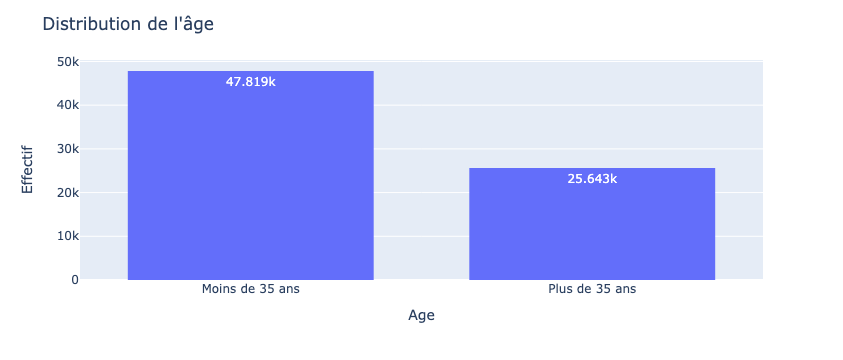

In [27]:
# 1. Graphe Age
fig_age = px.histogram(df_fr, x="Age", barmode="group", text_auto = True)

fig_age.update_layout(
    title_text="Distribution de l'âge",
    xaxis_title_text='Age', 
    yaxis_title_text="Effectif",
    bargap=0.2, 
    bargroupgap=0.1 
)

fig_age.show()

In [ ]:
# 2. Graphe Genre
fig_genre = px.histogram(df_fr, x="Gender", barmode="group", text_auto = True)

fig_genre.update_layout(
    title_text="Distribution du genre",
    xaxis_title_text='Genre', 
    yaxis_title_text="Effectif",
    bargap=0.2, 
    bargroupgap=0.1 
)

fig_genre.show()

In [ ]:
# 3. Graphe Niveau d'éducation
fig_ed = px.histogram(df_fr, x="EdLevel", barmode="group", 
                      text_auto = True, 
                      category_orders = dict(EdLevel = ["Pas d'éducation supérieure", "Licence", "Master", "Doctorat", "Autre"])
                     )

fig_ed.update_layout(
    title_text="Distribution du niveau d'éducation",
    xaxis_title_text="Niveau d'éducation", 
    yaxis_title_text="Effectif",
    bargap=0.2, 
    bargroupgap=0.1 
)

fig_ed.show()

In [ ]:
# 4. Graphe Branche pro
fig_branch = px.histogram(df_fr, x="MainBranch", barmode="group", text_auto = True)

fig_branch.update_layout(
    title_text="Distribution de la branche professionnelle",
    xaxis_title_text="Branche professionnelle (principale)", 
    yaxis_title_text="Effectif",
    bargap=0.2, 
    bargroupgap=0.1 
)

fig_branch.show()

**Distribution des variables numériques :**

In [ ]:
# 5. Graphe Années de code
fig_code = px.histogram(df_fr, x="YearsCode", barmode="group")

fig_code.update_layout(
    title_text="Distribution des années de code",
    xaxis_title_text="Nombre d'années de code", 
    yaxis_title_text="Effectif",
    bargap=0.2, 
    bargroupgap=0.1 
)

fig_code.show()

In [ ]:
# 6. Graphe Années de code pro
fig_codepro = px.histogram(df_fr, x="YearsCodePro", barmode="group")

fig_codepro.update_layout(
    title_text="Distribution des années de code professionnel",
    xaxis_title_text="Nombre d'années de code professionnel", 
    yaxis_title_text="Effectif",
    bargap=0.2, 
    bargroupgap=0.1 
)

fig_codepro.show()

In [ ]:
# 7. Graphe Salaire précédent
fig_salaire = px.histogram(df_fr, x="PreviousSalary", barmode="group")

fig_salaire.update_layout(
    title_text="Distribution du salaire précédent",
    xaxis_title_text="Salaire précédent", 
    yaxis_title_text="Effectif",
    bargap=0.2, 
    bargroupgap=0.1 
)

fig_salaire.show()

In [ ]:
# 8. Graphe Compétences en informatique
fig_info = px.histogram(df_fr, x="ComputerSkills", barmode="group")

fig_info.update_layout(
    title_text="Distribution des compétences en informatique",
    xaxis_title_text="Nombre de langages maîtrisés", 
    yaxis_title_text="Effectif",
    bargap=0.2, 
    bargroupgap=0.1 
)

fig_info.show()

### Taux d'emploi

In [ ]:
# Graphe Emploi
fig_emploi = px.histogram(df_fr, x="EmployedCat", barmode="group", text_auto = True)

fig_emploi.update_layout(
    title_text="Distribution du statut d'emploi",
    xaxis_title_text="Statut d'emploi", 
    yaxis_title_text="Effectif",
    bargap=0.2, 
    bargroupgap=0.1 
)

fig_emploi.show()

### Répartition géographique

In [ ]:
# Tableau nombre de répondants et taux d'emploi par pays
df_carto = df_fr.groupby(['Country','ISO'])['Employed'].agg(['count', 'mean']).reset_index()
df_carto.columns = ['Country', 'ISO', 'count', 'percentage']
df_carto['percentage'] *= 100

# 1. Carte du nb de développeurs
fig_nb = px.choropleth(df_carto, locations="ISO",
                    color="count",
                    hover_name="Country",
                    color_continuous_scale=px.colors.sequential.Plasma)

fig_nb.update_layout(
    title_text="Nombre de répondants par pays",
    coloraxis_colorbar_title_text = "Effectif",
)

fig_nb.show()

In [ ]:
# 2. Carte du taux d'emploi
# NB : on ne garde que les pays ayant au moins 100 répondants pour le calcul du taux d'emploi
fig_taux = px.choropleth(df_carto[df_carto['count']>100], locations="ISO",
                    color="percentage",
                    hover_name="Country",
                    color_continuous_scale=px.colors.sequential.Plasma)

fig_taux.update_layout(
    title_text="Taux d'emploi par pays (pour les pays ayant au moins 100 répondants)",
    coloraxis_colorbar_title_text = "Taux d'emploi",
)

fig_taux.show()

### Langages informatiques utilisés

**Nuage de mots des langages utilisés :**

In [ ]:
# Langages informatiques utilisés
languages = [str(cat).split(";") for cat in df["HaveWorkedWith"]]
languages_all = [item for sublist in languages for item in sublist]

# Décompte du nombre d'occurences de chaque langage
languages_count = Counter(languages_all)

# Création d'un nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(languages_count)

# Afficher le nuage de mots généré
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Tableau des 10 langages les plus employés :**

In [ ]:
top_languages = languages_count.most_common(10)

top_languages = pd.DataFrame(top_languages, columns = ["Langage", "Nombre d'occurences"], index = range(1,11))
top_languages

### Une autre mesure des compétences en informatique

Jusqu'ici, les compétences en informatique étaient mesurées via la variable `ComputerSkills` qui comptait le nombre de langages maîtrisés par chaque développeur. Ici, on crée une mesure alternative des compétences en informatique grâce à un décompte des langages maîtrisés parmi les 10 langages les plus courants dans la base.

In [ ]:
# Ajout d'une colonne qui compte le nombre de langages maîtrisés parmi les 10 plus courants
df_fr['LanguagesList'] = df_fr['HaveWorkedWith'].apply(lambda x: [] if pd.isna(x) else x.split(';'))

df_fr['TopLanguagesCount'] = df_fr['LanguagesList'].apply(lambda langlist: sum(lang in list(top_languages["Langage"]) for lang in langlist))

#print(df_fr['TopLanguagesCount'].isnull().sum())

#df_fr.head(10)

In [ ]:
# Graphe Langages parmi les top 10 langages
fig_info2 = px.histogram(df_fr, x="TopLanguagesCount", barmode="group")

fig_info2.update_layout(
    title_text="Distribution des compétences en informatique - mesure alternative",
    xaxis_title_text="Nombre de langages maîtrisés parmi les 10 les plus présents", 
    yaxis_title_text="Effectif",
    bargap=0.2, 
    bargroupgap=0.1 
)

fig_info2.show()

### Lien avec le statut d'emploi

**Variables catégorielles :**

In [ ]:
# 1. Graphe Age
# DF des Pourcentages Age
grouped_df_age = df_fr.groupby(['Age', 'EmployedCat'], observed = True).size().reset_index(name='count')
total_counts = df_fr.groupby('Age').size()

grouped_df_age['percentage'] = (grouped_df_age['count'] / grouped_df_age['Age'].map(total_counts) * 100).round(1)

# Graphe Pourcentages Age
fig_age = px.bar(grouped_df_age, orientation = 'h', x="percentage", y = "Age", color = "EmployedCat", 
                 text_auto = True,
                 category_orders = dict(Age = ["Moins de 35 ans", "Plus de 35 ans"])
)

fig_age.update_layout(
    title_text="Distribution du statut d'emploi selon l'âge",
    xaxis_title_text="Pourcentage", 
    yaxis_title_text="Age",
    legend_title_text = "Statut d'emploi",
    bargap=0.2, 
    bargroupgap=0.1 
)

fig_age.update_traces(texttemplate = '%{x}%')

fig_age.show()


In [ ]:
# 2. Graphe Genre
# DF des Pourcentages Genre
grouped_df_genre = df_fr.groupby(['Gender', 'EmployedCat'], observed = True).size().reset_index(name='count')
total_counts = df_fr.groupby('Gender').size()

grouped_df_genre['percentage'] = (grouped_df_genre['count'] / grouped_df_genre['Gender'].map(total_counts) * 100).round(1)

# Graphe Pourcentages Genre
fig_genre = px.bar(grouped_df_genre, orientation = 'h', x="percentage", y = "Gender", color = "EmployedCat", 
                   text_auto = True,
                   category_orders = dict(Gender = ["Homme", "Femme","Non-Binaire"])
)

fig_genre.update_layout(
    title_text="Distribution du statut d'emploi selon le genre",
    xaxis_title_text="Pourcentage", 
    yaxis_title_text="Genre",
    legend_title_text = "Statut d'emploi",
    bargap=0.2, 
    bargroupgap=0.1 
)

fig_genre.update_traces(texttemplate = '%{x}%')

fig_genre.show()

In [ ]:
# 3. Graphe Niveau d'éducation
# DF des Pourcentages Niveau d'éd
grouped_df_ed = df_fr.groupby(['EdLevel', 'EmployedCat'], observed = True).size().reset_index(name='count')
total_counts = df_fr.groupby('EdLevel').size()

grouped_df_ed['percentage'] = (grouped_df_ed['count'] / grouped_df_ed['EdLevel'].map(total_counts) * 100).round(1)

# Graphe Pourcentages Niveau d'éd
fig_ed = px.bar(grouped_df_ed, orientation = 'h', x="percentage", y = "EdLevel", color = "EmployedCat",
                text_auto = True,
                category_orders = dict(EdLevel = ["Pas d'éducation supérieure", "Licence", "Master", "Doctorat", "Autre"])
)

fig_ed.update_layout(
    title_text="Distribution du statut d'emploi selon le niveau d'éducation",
    xaxis_title_text="Pourcentage", 
    yaxis_title_text="Niveau d'éducation",
    legend_title_text = "Statut d'emploi",
    bargap=0.2, 
    bargroupgap=0.1 
)

fig_ed.update_traces(texttemplate = '%{x}%')

fig_ed.show()

In [ ]:
# 4. Graphe Branche pro
# DF des Pourcentages Branche pro
grouped_df_branch = df_fr.groupby(['MainBranch', 'EmployedCat'], observed = True).size().reset_index(name='count')
total_counts = df_fr.groupby('MainBranch').size()

grouped_df_branch['percentage'] = (grouped_df_branch['count'] / grouped_df_branch['MainBranch'].map(total_counts) * 100).round(1)

# Graphe Pourcentages Branche pro
fig_branch = px.bar(grouped_df_branch, orientation = 'h', x="percentage", y = "MainBranch", color = "EmployedCat", text_auto = True,
                    category_orders = dict(MainBranch = ["Développement", "Autre"])
                   )

fig_branch.update_layout(
    title_text="Distribution du statut d'emploi selon la branche professionnelle",
    xaxis_title_text="Pourcentage", 
    yaxis_title_text="Branche professionnelle principale",
    legend_title_text = "Statut d'emploi",
    bargap=0.2, 
    bargroupgap=0.1 
)

fig_branch.update_traces(texttemplate = '%{x}%')

fig_branch.show()

**Variables numériques :**

In [ ]:
# 1. Années de code vs. statut d'emploi
fig_code = px.box(df_fr, x="EmployedCat", y = "YearsCode")

fig_code.update_layout(
    title_text="Distribution des années de code selon le statut d'emploi",
    xaxis_title_text="Statut d'emploi", 
    yaxis_title_text="Années de code",
    bargap=0.2, 
    bargroupgap=0.1 
)

fig_code.show()

In [ ]:
# 2. Années de code pro vs. statut d'emploi
fig_codepro = px.box(df_fr, x="EmployedCat", y = "YearsCodePro")

fig_codepro.update_layout(
    title_text="Distribution des années de code professionnel selon le statut d'emploi",
    xaxis_title_text="Statut d'emploi", 
    yaxis_title_text="Années de code professionnel",
    bargap=0.2, 
    bargroupgap=0.1 
)

fig_codepro.show()


In [ ]:
# 3. Salaire précédent vs. statut d'emploi
fig_salaire = px.box(df_fr, x="EmployedCat", y = "PreviousSalary")

fig_salaire.update_layout(
    title_text="Distribution du salaire précédent selon le statut d'emploi",
    xaxis_title_text="Statut d'emploi", 
    yaxis_title_text="Salaire précédent",
    bargap=0.2, 
    bargroupgap=0.1 
)

fig_salaire.show()

In [ ]:
# 4. Compétences en informatique vs. statut d'emploi
fig_info = px.box(df_fr, x="EmployedCat", y = "ComputerSkills")

fig_info.update_layout(
    title_text="Distribution des compétences en informatique (nombre de langages maîtrisés) selon le statut d'emploi",
    xaxis_title_text="Statut d'emploi", 
    yaxis_title_text="Nombre de langages maîtrisés",
    bargap=0.2, 
    bargroupgap=0.1 
)

fig_info.show()

In [ ]:
# 5. Compétences en informatique - mesure alternative vs. statut d'emploi
fig_info2 = px.box(df_fr, x="EmployedCat", y = "TopLanguagesCount")

fig_info2.update_layout(
    title_text="Distribution des compétences en informatique (mesure alternative) selon le statut d'emploi",
    xaxis_title_text="Statut d'emploi", 
    yaxis_title_text="Nombre de langages maîtrisés parmi les 10 langages les plus présents",
    bargap=0.2, 
    bargroupgap=0.1 
)

fig_info2.show()

# 5. Modélisation

## Premiers modèles "baseline"

#### Construction des premiers modèles

In [ ]:
preprocess = make_column_transformer(
    (StandardScaler(), num),
    (OneHotEncoder(), cat))
X1=df[['Age', 'Accessibility', 'EdLevel', 'Gender', 'MentalHealth', 'MainBranch','YearsCode', 'YearsCodePro', 'PreviousSalary', 'ComputerSkills']]
y1=df['Employed']

X1_train, X1_test, y1_train, y1_test=train_test_split(X1, y1, test_size = 0.25, random_state = 4)

In [ ]:
# Avec l'échantillon d'origine
# Régression logistique
cv_lr1 = make_pipeline(
    preprocess,
    LogisticRegression(penalty='l2'))
cv_lr1.fit(X1_train, y1_train)

# Arbre de décision
cv_tree1 = make_pipeline(preprocess, DecisionTreeClassifier(max_depth=7, random_state=123))
cv_tree1.fit(X1_train, y1_train)

# Forêt aléatoire
cv_forest1 = make_pipeline(preprocess, RandomForestClassifier(n_estimators=200, max_depth=7, random_state=123))
cv_forest1.fit(X1_train, y1_train)

# XGBoost
cv_xg1 = make_pipeline(preprocess, xgb.XGBClassifier(objective='multi:softmax', num_class=3, max_depth=3, learning_rate=0.1, n_estimators=100))
cv_xg1.fit(X1_train, y1_train)


In [ ]:
from joblib import dump

# Sauvegarde des modèles
dump(cv_lr1, 'modeles/logistic_regression_baseline.joblib')
dump(cv_tree1, 'modeles/decision_tree_baseline.joblib')
dump(cv_forest1, 'modeles/random_forest_baseline.joblib')
dump(cv_xg1, 'modeles/xgboost_baseline.joblib')

In [ ]:
# Créer un Explainer pour le Pipeline
#exp_tree_b = dx.Explainer(cv_tree1, X1_test, y1_test, verbose=False)
#exp_forest_b = dx.Explainer(cv_forest1, X1_test, y1_test, verbose=False)
#exp_b = dx.Explainer(cv_lr1, X1_test, y1_test, label='Logistic regression Pipeline')
#exp_xg_b=dx.Explainer(cv_xg1, X1_test, y1_test, verbose=False)

# Générer des explications
#explanations_dt_b = exp_tree_b.model_parts()
#explanations_rf_b = exp_forest_b.model_parts()
#explanations_lr_b = exp_b.model_parts()
#explanations_xg_b = exp_xg_b.model_parts()

# Sauvegarder ces explications dans des fichiers txt
#explanations_dt_b_txt = str(exp_tree_b.model_parts())
#explanations_rf_b_txt = str(exp_forest_b.model_parts())
#explanations_lr_b_txt = str(exp_b.model_parts())
#explanations_xg_b_txt = str(exp_xg_b.model_parts())

# Enregistrer les explanations dans le dossier
#with open('explanations/explanations_dt_b_txt.txt', 'w') as file:
#    file.write(explanations_dt_b_txt)
#with open('explanations/explanations_rf_b_txt.txt', 'w') as file:
#    file.write(explanations_rf_b_txt)
#with open('explanations/explanations_lr_b_txt.txt', 'w') as file:
#    file.write(explanations_lr_b_txt)
#with open('explanations/explanations_xg_b_txt.txt', 'w') as file:
#    file.write(explanations_xg_b_txt)

#### Étude de la performance et de l'équité

Commençons par un petit mot sur la mesure de l'équité de nos modèles. En effet, pour faciliter le développement d'un modèle responsable, nous utilisons le package Python dalex : https://dalex.drwhy.ai/

Citant le tutoriel de Dalex :

> L'idée est que les rapports entre les scores des métriques privilégiées et non privilégiées devraient être proches de 1. Plus ils le sont, plus c'est équitable. Pour assouplir un peu ce critère, cela peut être formulé de manière plus réfléchie :

> $$ \forall i \in \{a, b, ..., z\}, \quad \epsilon < \frac{métrique_i}{métrique_{privilégiée}} < \frac{1}{\epsilon}.$$

> Où epsilon est une valeur comprise entre 0 et 1, elle devrait être une valeur minimale acceptable du rapport. Par défaut, elle est de 0.8, ce qui respecte la règle des quatre cinquièmes (règle des 80%) souvent observée dans l'embauche, par exemple.


Description des métriques utilisées pour l'évaluation de la performance en termes d'équité pour chaque stratégie :

- **Ratio d'opportunité égale** calculé à partir du taux de vrais positifs (rappel)

> Ce nombre décrit les proportions d'instances positives correctement classifiées.

> $TPR = \frac{TP}{P}$

- **Ratio de parité prédictive** calculé à partir de la valeur prédictive positive (précision)

> Ce nombre décrit le ratio d'échantillons qui ont été correctement classifiés comme positifs parmi toutes les prédictions positives.

> $PPV = \frac{TP}{TP + FP}$

- **Ratio d'égalité de précision** calculé à partir de la précision

> Ce nombre est le ratio des instances correctement classifiées (positives et négatives) parmi toutes les décisions.

> $ACC = \frac{TP + TN}{TP + FP + TN + FN}$

- **Ratio d'égalité prédictive** calculé à partir du taux de faux positifs

> Ce nombre décrit la part de négatifs réels qui ont été faussement classifiés comme positifs.

> $FPR = \frac{FP}{TP + TN}$

- **Ratio de parité statistique** calculé à partir du taux de positifs

> Ce nombre est le taux global d'instances classifiées positivement, incluant à la fois les décisions correctes et incorrectes.

> $PR = \frac{TP + FP}{TP + FP + TN + FN}$


In [ ]:
# Créer un Explainer pour le Pipeline
exp_tree1 = dx.Explainer(cv_tree1, X1_test, y1_test, verbose=False)
exp_forest1 = dx.Explainer(cv_forest1, X1_test, y1_test, verbose=False)
exp1 = dx.Explainer(cv_lr1, X1_test, y1_test, label='Logistic regression Pipeline')
exp_xg1=dx.Explainer(cv_xg1, X1_test, y1_test, verbose=False)

In [ ]:
# Performance du modèle
pd.concat([exp.model_performance().result for exp in [exp1, exp_tree1, exp_forest1,exp_xg1]])

In [ ]:
# Importance des variables
exp_tree1.model_parts().plot(objects=[exp_forest1.model_parts(), exp1.model_parts(),exp_xg1.model_parts()])

In [ ]:
# Preparation pour le test d'équité de Gender
protected = X1_test.Gender 
mf_tree1 = exp_tree1.model_fairness(protected=protected,
                                  privileged = "Woman")

mf_forest1 = exp_forest1.model_fairness(protected=protected,
                                  privileged = "Woman")

mf_log1 = exp1.model_fairness(protected=protected,
                                  privileged = "Woman")
mf_xg1=exp_xg1.model_fairness(protected=protected,
                                  privileged = "Woman")

In [ ]:
mf_tree1.fairness_check()
mf_forest1.fairness_check()
mf_log1.fairness_check()
mf_xg1.fairness_check()

In [ ]:
mf_tree1.plot(objects=[mf_log1, mf_forest1,mf_xg1],
             type="performance_and_fairness",
             fairness_metric="FPR",
             performance_metric="accuracy")

#### Un exemple pour mieux comprendre

In [ ]:
john = pd.DataFrame({'Age': '<35',
                       'Accessibility': ['Yes'],
                       'EdLevel': ['PhD'],
                       'Gender': ['Man'],
                       'MentalHealth': ['No'],
                       'MainBranch': ['Dev'],
                       'YearsCode':[14],
                       'YearsCodePro':[7],
                       'PreviousSalary': [60000],
                       'ComputerSkills': [7]
                     },
                      index = ['John'])
mary = pd.DataFrame({'Age': '<35',
                       'Accessibility': ['Yes'],
                       'EdLevel': ['PhD'],
                       'Gender': ['Woman'],
                       'MentalHealth': ['No'],
                       'MainBranch': ['Dev'],
                       'YearsCode':[14],
                       'YearsCodePro':[7],
                       'PreviousSalary': [60000],
                       'ComputerSkills': [7]
                     },
                      index = ['Mary'])
jean = pd.DataFrame({'Age': '<35',
                       'Accessibility': ['Yes'],
                       'EdLevel': ['PhD'],
                       'Gender': ['NonBinary'],
                       'MentalHealth': ['No'],
                       'MainBranch': ['Dev'],
                       'YearsCode':[14],
                       'YearsCodePro':[7],
                       'PreviousSalary': [60000],
                       'ComputerSkills': [7]
                     },
                      index = ['Jean'])

In [ ]:
bd_john = exp_xg1.predict_parts(john, type='break_down', label=john.index[0])
bd_mary = exp_xg1.predict_parts(mary, type='break_down', label=mary.index[0])
bd_jean = exp_xg1.predict_parts(jean, type='break_down', label=jean.index[0])
bd_interactions_john = exp_xg1.predict_parts(john, type='break_down_interactions', label="John+")
bd_interactions_mary = exp_xg1.predict_parts(mary, type='break_down_interactions', label="Mary+")
bd_interactions_jean = exp_xg1.predict_parts(jean, type='break_down_interactions', label="Jean+")
sh_john = exp_xg1.predict_parts(john, type='shap', B = 10, label=john.index[0])
sh_mary = exp_xg1.predict_parts(mary, type='shap', B = 10, label=mary.index[0])
sh_jean = exp_xg1.predict_parts(jean, type='shap', B = 10, label=jean.index[0])

In [ ]:
sh_john.plot(bar_width = 16)

In [ ]:
sh_mary.plot(bar_width = 16)

In [ ]:
sh_jean.plot(bar_width = 16)

Nos modèles baseline sont biaisés, nous allons donc essayer de réflechir aux solutions que l'on peut adopter pour mitiger ce biais.

## Réflexion sur les solutions possibles pour corriger les biais détectés

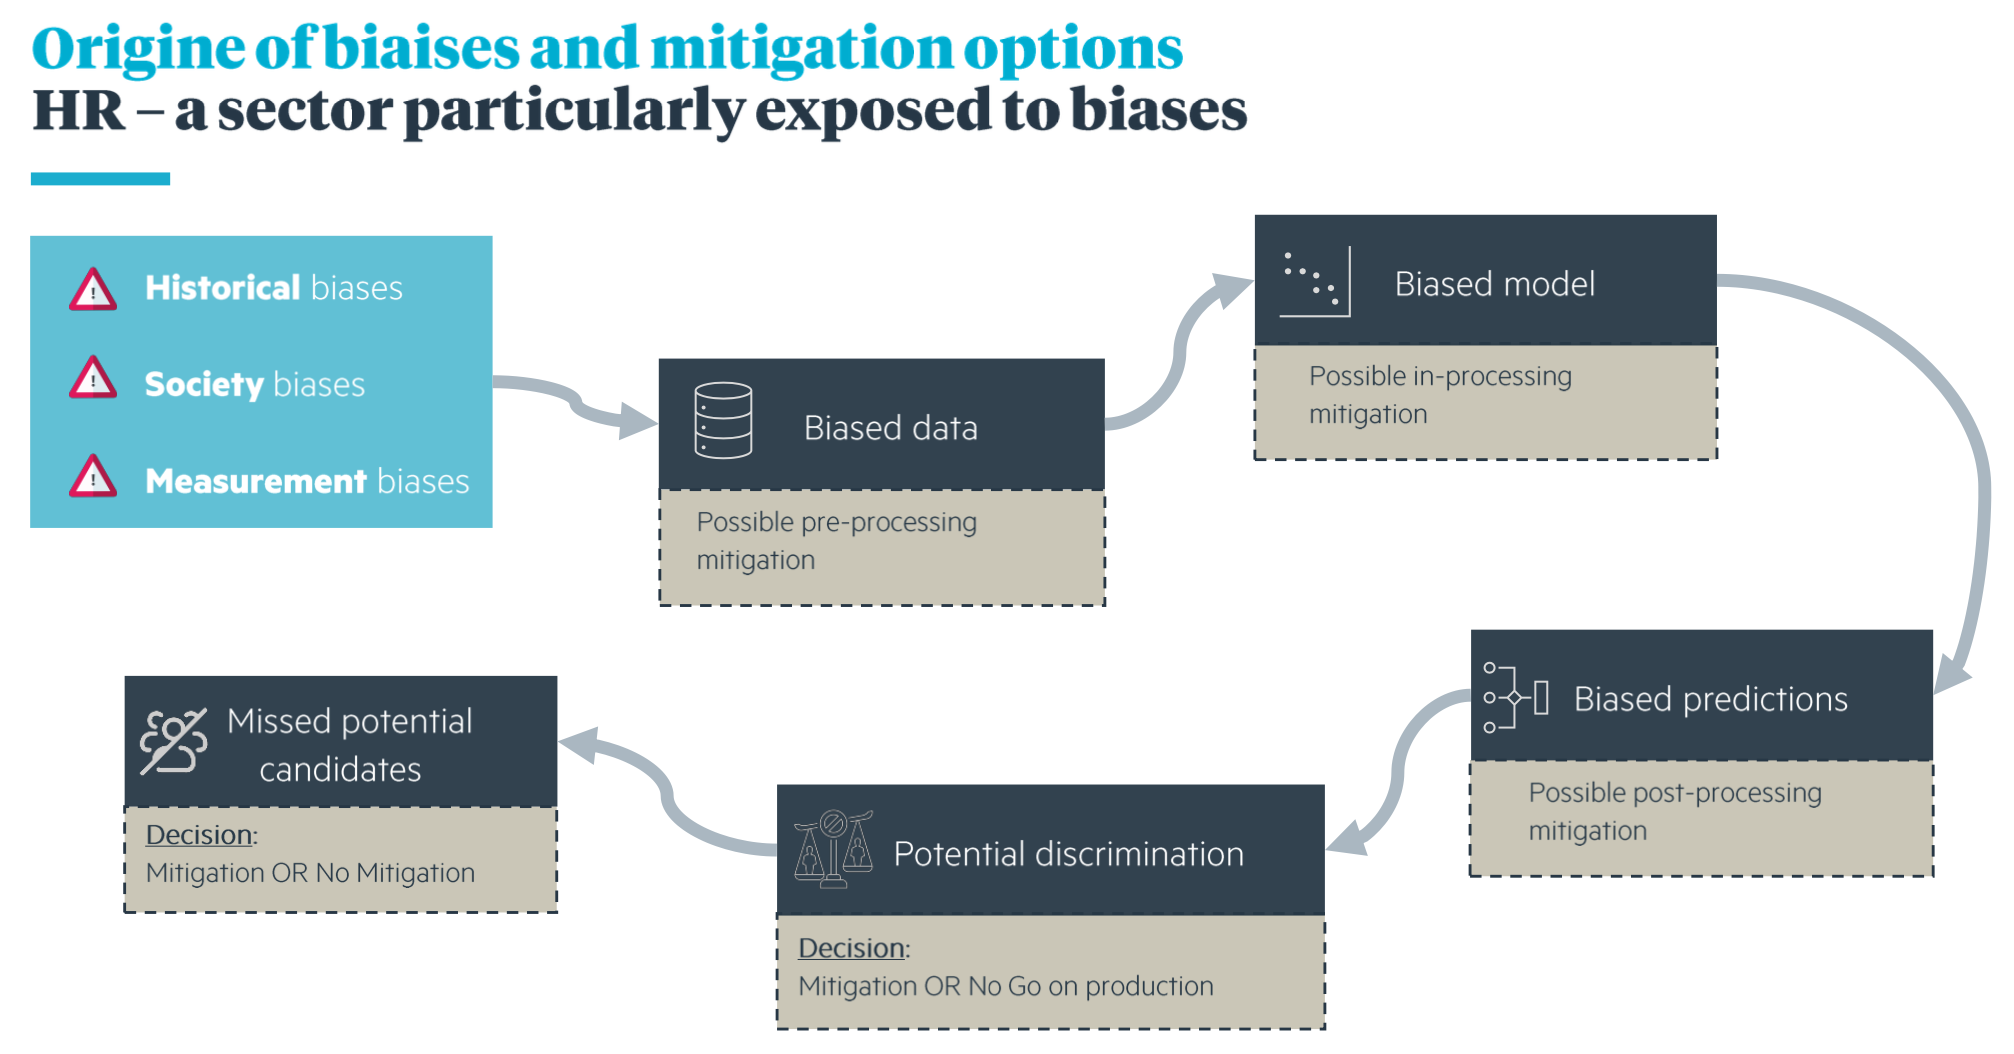

##### Traitement des biais historiques, sociaux et de mesure
- **Biais historiques** : Mettre à jour les ensembles de données avec des informations plus récentes ou utiliser des techniques pour rééquilibrer les données.
- **Biais sociaux** : Mettre en place des programmes de sensibilisation et réviser les processus de recrutement pour les rendre plus objectifs et inclusifs.
- **Biais de mesure** : S'assurer d'avoir un échantillon diversifié et représentatif, et utiliser plusieurs sources de données.


##### Atténuation du prétraitement
- **Nettoyage des données** : Gérer les valeurs manquantes et les erreurs qui peuvent affecter certains groupes.
- **Sélection des caractéristiques** : Choisir des caractéristiques qui n'incluent pas de variables de substitution pour les attributs protégés.
- **Ré-échantillonnage ou ré-pondération** : Équilibrer l'ensemble de données en suréchantillonnant les groupes sous-représentés.


##### Atténuation en cours de traitement
- **Sélection d'algorithmes** : Choisir des algorithmes moins sensibles aux déséquilibres.
- **Incorporer des contraintes d'équité** : Modifier les algorithmes pour inclure l'équité pendant l'entraînement.
- **Validation** : Utiliser la validation croisée pour garantir des performances équitables entre les sous-groupes.


##### Atténuation après le traitement
- **Ajustement des seuils de décision** : Égaliser les faux positifs et les faux négatifs entre les groupes.
- **Étalonnage** : Ajuster les prédictions pour garantir la cohérence.
- **Analyse des résultats** : Analyser les décisions en termes d'équité avant de les finaliser.


##### Points de décision
- **Après le prétraitement** : Déterminer l'efficacité de l'atténuation des biais avant l'entraînement.
- **Après les prédictions** : Décider du déploiement du modèle en fonction de l'analyse de l'équité.


##### Surveillance et rétroaction
- **Surveillance des résultats** : Évaluer les résultats du processus de recrutement à la recherche de signes de biais.
- **Collecte de rétroaction** : Mettre en place des mécanismes de rétroaction auprès des candidats et des employés.


## Mitigation des biais et nouveaux modèles

### Pre-processing Mitigation

In [ ]:
# NETTOYAGE DES DONNÉES
# Effectué lors de l'exploration des données

# SÉLECTION DES CARACTÉRISTIQUES
# Suppression des caractéristiques qui pourraient être des proxies pour des attributs protégés (comme 'Country' s'il est un proxy pour l'origine ethnique)
#df = df.drop(['Country'], axis=1)

# RÉ-ÉCHANTILLONNAGE
# Identification de la variable cible
target_column = 'Employed'

# Séparation de l'ensemble de données en classes majoritaires et minoritaires en fonction de la variable cible
majority_class = df[df[target_column] == df[target_column].mode()[0]]  
minority_class = df[df[target_column] != df[target_column].mode()[0]]  

# Sur-échantillonnage de la classe minoritaire
minority_upsampled = resample(minority_class,
                              replace=True,      
                              n_samples=len(majority_class), 
                              random_state=123) 

# Combinaison de la classe majoritaire avec la classe minoritaire sur-échantillonnée
upsampled_data = pd.concat([majority_class, minority_upsampled])

# Mélanger les données pour éviter tout biais d'ordre
upsampled_data = upsampled_data.sample(frac=1, random_state=123).reset_index(drop=True)

# L'ensemble de données 'upsampled_data' est maintenant un ensemble de données équilibré
upsampled_data.head()

### In-processing Mitigation

**Data Preprocessing & Preparation for Modeling**

- Utilisation de StandardScaler pour normaliser les variables numériques et de OneHotEncoder pour transformer les variables catégorielles en vecteurs binaires.
- Création d'un transformateur de colonnes (make_column_transformer) pour appliquer ces prétraitements aux colonnes appropriées.

- Sélection des caractéristiques d'apprentissage (X) et de la variable cible (y).
- Division des données en ensembles d'entraînement et de test (train_test_split).


In [ ]:
X=upsampled_data[['Age', 'Accessibility', 'EdLevel', 'Gender', 'MentalHealth', 'MainBranch','YearsCode', 'YearsCodePro', 'PreviousSalary', 'ComputerSkills']]
y=upsampled_data['Employed']

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size = 0.25, random_state = 4)

**Creation and Training of Classification Models**

- Utilisation de différents algorithmes (régression logistique, arbre de décision, forêt aléatoire, XGBoost) intégrés dans des pipelines pour automatiser le flux de prétraitement et d'apprentissage.


In [ ]:
#Avec les données pré-traitées
#Logistic regression
cv_lr = make_pipeline(
    preprocess,
    LogisticRegression(penalty = 'l2'))
cv_lr.fit(X_train, y_train)

#Decision Tree
cv_tree = make_pipeline(preprocess, DecisionTreeClassifier(max_depth=7, random_state=123))
cv_tree.fit(X_train, y_train)

#Random Forest
cv_forest = make_pipeline(preprocess, RandomForestClassifier(n_estimators=200, max_depth=7, random_state=123))
cv_forest.fit(X_train, y_train)

#XGBoost
cv_xg = make_pipeline(preprocess,xgb.XGBClassifier(objective='multi:softmax', num_class=3, max_depth=3, learning_rate=0.1, n_estimators=100))
cv_xg.fit(X_train, y_train)

In [ ]:
# Sauvegarde des modèles
dump(cv_lr, 'modeles/logistic_regression.joblib')
dump(cv_tree, 'modeles/decision_tree.joblib')
dump(cv_forest, 'modeles/random_forest.joblib')
dump(cv_xg, 'modeles/xgboost.joblib')

**Performance Analysis**

- Utilisation de dalex pour créer des "explainers" de modèle qui permettent l'analyse des performances et de l'importance des variables.
- Constat que "ComputerSkills" est la caractéristique la plus importante dans tous les modèles.


In [ ]:
# Créer un Explainer pour le Pipeline
exp_tree = dx.Explainer(cv_tree, X_test, y_test, verbose=False)
exp_forest = dx.Explainer(cv_forest, X_test, y_test, verbose=False)
exp = dx.Explainer(cv_lr, X_test, y_test, label='Logistic regression Pipeline')
exp_xg=dx.Explainer(cv_xg, X_test, y_test, verbose=False)

In [ ]:
# Performance du modèle
pd.concat([exp.model_performance().result for exp in [exp, exp_tree, exp_forest,exp_xg]])

In [ ]:
# Importance des variables
exp_tree.model_parts().plot(objects=[exp_forest.model_parts(), exp.model_parts(),exp_xg.model_parts()])

**Analysis of Algorithmic Fairness (Fairness)**

- Vérification de l'équité des modèles en se concentrant sur le genre en tant que variable protégée.
- Utilisation de différentes méthodes (vérification de l'équité, visualisation) pour évaluer et représenter graphiquement l'égalité entre les groupes.


In [ ]:
# Preparation du Test Fairness
protected = X_test.Gender
mf_tree = exp_tree.model_fairness(protected=protected,
                                  privileged = "Woman")

mf_forest = exp_forest.model_fairness(protected=protected,
                                  privileged = "Woman")

mf_log = exp.model_fairness(protected=protected,
                                  privileged = "Woman")
mf_xg=exp_xg.model_fairness(protected=protected,
                                  privileged = "Woman")

In [ ]:
mf_tree.fairness_check()

In [ ]:
mf_forest.fairness_check()

In [ ]:
mf_log.fairness_check()

In [ ]:
mf_xg.fairness_check()

On remarque que tous les classifiers sont biaisés. Essayons de quantifier le biais.

In [ ]:
mf_tree.plot(objects=[mf_log, mf_forest, mf_xg])

On observe que le biais ne semble pas très élevé.

In [ ]:
mf_tree.plot(objects=[mf_log, mf_forest,mf_xg], type='stacked')

Le DecisionTreeClassifier semble avoir la plus petite parity loss.

In [ ]:
mf_tree.plot(objects=[mf_log, mf_forest,mf_xg],
             type="performance_and_fairness",
             fairness_metric="FPR",
             performance_metric="accuracy")

Plus l'exactitude est élevée, plus la perte de parité est grande.
Existe-t-il une méthode qui nous permettrait d'atténuer les biais ? Oui, et nous en essaierons quelques-unes dans la prochaine section.

**Bias Mitigation**

- Application de techniques telles que "ceteris paribus cutoff," "roc_pivot," "resample," "reweight" pour tenter de réduire les biais dans les modèles.
- Reformation des modèles avec ces techniques et évaluation de l'équité après atténuation.

*Ceteris Paribus Cutoff*

La méthode "ceteris paribus cutoff" pour atténuer les biais dans les modèles d'apprentissage automatique consiste à identifier un seuil de décision optimal qui équilibre l'équité et les performances. Cette approche ajuste le seuil de classification tout en maintenant les autres paramètres du modèle constants, dans le but de minimiser les disparités dans les métriques d'équité entre différents groupes. Elle est particulièrement utile dans les scénarios où il existe un compromis entre la précision du modèle et l'équité des prédictions pour les sous-groupes protégés.

In [ ]:
mf_tree.plot(objects=[mf_log, mf_forest,mf_xg], type="ceteris_paribus_cutoff", subgroup="Woman")

*ROC Pivot*

Cette méthode ajuste le seuil de décision en fonction de la courbe ROC (Receiver Operating Characteristic) pour équilibrer la sensibilité et la spécificité, dans le but d'améliorer l'équité des prédictions tout en maintenant les performances du modèle.

In [ ]:
from dalex.fairness import resample, reweight, roc_pivot

In [ ]:
privileged="Woman"
exp1 = copy(exp)
exp2 = copy(exp_forest)
exp3=copy(exp_tree)
expg=copy(exp_xg)
# roc pivot
exp1 = roc_pivot(exp1, protected, privileged, theta = 0.02, verbose = False)
exp2 = roc_pivot(exp2, protected, privileged, theta = 0.02, verbose = False)
exp3 = roc_pivot(exp3, protected, privileged, theta = 0.02, verbose = False)
expg = roc_pivot(expg, protected, privileged, theta = 0.02, verbose = False)


In [ ]:
fobject1 = exp1.model_fairness(protected, privileged, label='roc Logistic')
fobject2 = exp2.model_fairness(protected, privileged, label='roc forest')
fobject3 = exp3.model_fairness(protected, privileged, label='roc tree')
fobjectg = expg.model_fairness(protected, privileged, label='roc xg')

In [ ]:
fobject1.plot([fobject2,fobject3,fobjectg])

In [ ]:
fobjectg.fairness_check()

In [ ]:
fobject1.fairness_check()

In [ ]:
fobject2.fairness_check()

In [ ]:
fobject3.fairness_check()

*Resample*

Cette approche consiste à modifier l'ensemble de données d'entraînement en suréchantillonnant les groupes sous-représentés ou en sous-échantillonnant les groupes surreprésentés, créant ainsi un ensemble de données plus équilibré qui peut conduire à des résultats de modèle plus équitables.

In [ ]:
# copying
clf_u = copy(cv_lr)
clf_p = copy(cv_lr)
clfx=copy(cv_xg)
clfx2=copy(cv_xg)

In [ ]:
indices_uniform = resample(X_test.Gender, y_test, verbose = False)
indices_preferential = resample(X_test.Gender,
                                y_test,
                                type = 'preferential', # different type
                                probs = exp.y_hat, # requires probabilities
                                verbose = False)


clf_u.fit(X_test.iloc[indices_uniform, :], y_test.iloc[indices_uniform])
clf_p.fit(X_test.iloc[indices_preferential, :], y_test.iloc[indices_preferential])
clfx.fit(X_test.iloc[indices_preferential, :], y_test.iloc[indices_preferential])
clfx2.fit(X_test.iloc[indices_uniform, :], y_test.iloc[indices_uniform])


In [ ]:
exp3u = dx.Explainer(clf_u, X_test, y_test, verbose = False)
exp3p = dx.Explainer(clf_p, X_test, y_test, verbose = False)
exp3x = dx.Explainer(clfx, X_test, y_test, verbose = False)
exp3x1 = dx.Explainer(clfx2, X_test, y_test, verbose = False)

In [ ]:
fobject3u = exp3u.model_fairness(protected, privileged, label='res_unif_lr')
fobject3p = exp3p.model_fairness(protected, privileged, label='res_pref_lr')
fobject3xx = exp3x.model_fairness(protected, privileged, label='res_pref_xg')
fobject3x1 = exp3x1.model_fairness(protected, privileged, label='res_unif_xg')

In [ ]:
fobject3u.fairness_check()

In [ ]:
fobject3p.fairness_check()

In [ ]:
fobject3x1.fairness_check()

In [ ]:
fobject3xx.fairness_check()

*Reweight*

Cette technique ajuste les poids attribués aux différents échantillons de l'ensemble de données d'entraînement, accordant davantage d'importance aux groupes sous-représentés. Cela contribue à réduire les biais en veillant à ce que le modèle accorde plus d'attention à ces groupes pendant l'entraînement.

Régression logistique :

In [ ]:
weights = reweight(protected, y_test, verbose = False)

cv_weighted_lr = copy(cv_lr)

kwargs = {cv_weighted_lr.steps[-1][0] + '__sample_weight': weights}

cv_weighted_lr.fit(X_test,y_test, **kwargs)

In [ ]:
dump(cv_weighted_lr, 'modeles/test_lr.joblib')

In [ ]:
expw_lr = dx.Explainer(cv_weighted_lr, X_test, y_test, verbose = False)
fobjectw_lr = expw_lr.model_fairness(protected, privileged, label='weighted')
fobjectw_lr.fairness_check()

In [ ]:
fobject3wp = expw_lr.model_fairness(X_test.Age, '<35', label='weighted')
fobject3wp.fairness_check()

In [ ]:
fobject3wp = expw_lr.model_fairness(X_test.MentalHealth, 'No', label='weighted')
fobject3wp.fairness_check()

In [ ]:
fobject3wp = expw_lr.model_fairness(X_test.Accessibility, 'No', label='weighted')
fobject3wp.fairness_check()

C'est beaucoup mieux qu'auparavant. Nous avons décidé d'essayer avec l'arbre de décision et le XGBoost.

Essayons avec un arbre de décision : 

In [ ]:
clf_weighted_forest = copy(cv_forest)

kwargs = {clf_weighted_forest.steps[-1][0] + '__sample_weight': weights}

clf_weighted_forest.fit(X_test,y_test, **kwargs)

In [ ]:
dump(clf_weighted_forest, 'modeles/test_forest.joblib')

In [ ]:
expwt = dx.Explainer(clf_weighted_forest, X_test, y_test, verbose = False)
fobject3wt = expwt.model_fairness(protected, privileged, label='weighted')
fobject3wt.fairness_check()

Essayons avec le xgboost :

In [ ]:
clf_weighted_xg = copy(cv_xg)

kwargs = {clf_weighted_xg.steps[-1][0] + '__sample_weight': weights}

clf_weighted_xg.fit(X_test,y_test, **kwargs)

In [ ]:
dump(clf_weighted_xg, 'modeles/test_xgb.joblib')

In [ ]:
expxg = dx.Explainer(clf_weighted_xg, X_test, y_test, verbose = False)
fobjectxg = expxg.model_fairness(protected, privileged, label='weighted')
fobjectxg.fairness_check()

In [ ]:
fobjectxg = expxg.model_fairness(X_test.Accessibility, 'No', label='weighted')
fobjectxg.fairness_check()

In [ ]:
fobjectxg = expxg.model_fairness(X_test.MentalHealth, 'No', label='weighted')
fobjectxg.fairness_check()

In [ ]:
fobjectxg = expxg.model_fairness(X_test.Age, '<35', label='weighted')
fobjectxg.fairness_check()

In [ ]:
fobjectxg.plot()

Donc, l'atténuation du modèle XGBoost avec la répartition tend à le rendre équitable par rapport aux variables : l'âge, le genre, l'accessibilité et la santé mentale.

##### Detailed Analysis with Dalex

- Utilisation de model_parts, model_performance et d'autres outils de Dalex pour une analyse plus approfondie.
- Évaluation de l'impact des différentes caractéristiques sur les prédictions des modèles à l'aide de techniques telles que SHAP (SHapley Additive exPlanations) et Break Down (BD).

In [ ]:
explanation=expxg.model_parts()
explanation.result
explanation.plot()

In [ ]:
explanationp=exp_xg1.model_parts()
explanationp.result
explanationp.plot()

In [ ]:
mp = expxg.model_performance(model_type = 'classification')
mp.result

In [ ]:
mp.plot(geom="roc")

## Post-processing Mitigation/Evaluation

#### Complementary Analysis

- Utilisation de la validation croisée pour évaluer les performances du modèle XGBoost.
- Analyse des profils du modèle (PDP - Partial Dependence Plots, ALE - Accumulated Local Effects) pour comprendre comment différentes caractéristiques influencent les prédictions.

In [ ]:
# Effectuer une validation croisée
cv_scores = cross_val_score(cv_xg, X_train, y_train, cv=5, scoring='accuracy')

# Afficher les scores de validation croisée
print("Scores de validation croisée :", cv_scores)
print("Précision moyenne : {:.2f}".format(cv_scores.mean()))

In [ ]:
param_grid = {
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],
    'xgbclassifier__max_depth': [3, 4, 5],
    'xgbclassifier__n_estimators': [50, 100, 200]
}

# Choisissez une stratégie de validation croisée, par exemple, une validation croisée à 5 plis
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Créez un pipeline avec prétraitement et XGBoost
xgb_model = make_pipeline(preprocess, xgb.XGBClassifier())

# Configurez GridSearchCV avec le pipeline
grid_search = GridSearchCV(xgb_model, param_grid, cv=kf, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Affichez les meilleurs hyperparamètres
print("Meilleurs Hyperparamètres : ", grid_search.best_params_)

# Évaluez sur l'ensemble de test
y_pred = grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Erreur quadratique moyenne sur l'ensemble de test : ", mse)


In [ ]:
ale_num = expxg.model_profile(type = 'accumulated', label="ale")

In [ ]:
pdp_num = expxg.model_profile(type = 'partial', label="pdp")

In [ ]:
pdp_num.plot(ale_num)

##### Interpretation/Visualisation de notre meilleur modèle (XGBoost)

In [ ]:
john = pd.DataFrame({'Age': '<35',
                       'Accessibility': ['Yes'],
                       'EdLevel': ['PhD'],
                       'Gender': ['Man'],
                       'MentalHealth': ['No'],
                       'MainBranch': ['Dev'],
                       'YearsCode':[4],
                       'YearsCodePro':[7],
                       'PreviousSalary': [60000],
                       'ComputerSkills': [7]
                     },
                      index = ['John'])
mary = pd.DataFrame({'Age': '<35',
                       'Accessibility': ['Yes'],
                       'EdLevel': ['PhD'],
                       'Gender': ['Woman'],
                       'MentalHealth': ['No'],
                       'MainBranch': ['Dev'],
                       'YearsCode':[4],
                       'YearsCodePro':[7],
                       'PreviousSalary': [60000],
                       'ComputerSkills': [7]
                     },
                      index = ['Mary'])
jean = pd.DataFrame({'Age': '<35',
                       'Accessibility': ['Yes'],
                       'EdLevel': ['PhD'],
                       'Gender': ['NonBinary'],
                       'MentalHealth': ['No'],
                       'MainBranch': ['Dev'],
                       'YearsCode':[4],
                       'YearsCodePro':[7],
                       'PreviousSalary': [60000],
                       'ComputerSkills': [7]
                     },
                      index = ['Jean'])

In [ ]:
bd_john = expxg.predict_parts(john, type='break_down', label=john.index[0])
bd_mary1 = expxg.predict_parts(mary, type='break_down', label=mary.index[0])
bd_jean = expxg.predict_parts(jean, type='break_down', label=jean.index[0])
bd_interactions_john = expxg.predict_parts(john, type='break_down_interactions', label="John+")
bd_interactions_mary1 = expxg.predict_parts(mary, type='break_down_interactions', label="Mary+")
bd_interactions_jean = expxg.predict_parts(jean, type='break_down_interactions', label="Jean+")
sh_john1 = expxg.predict_parts(john, type='shap', B = 10, label=john.index[0])
sh_mary1 = expxg.predict_parts(mary, type='shap', B = 10, label=mary.index[0])
sh_jean = expxg.predict_parts(jean, type='shap', B = 10, label=jean.index[0])

In [ ]:
bd_john.plot(bd_interactions_john)

In [ ]:
bd_mary1.plot(bd_interactions_mary1)

In [ ]:
sh_mary1.plot(bar_width = 16)

In [ ]:
sh_john1.plot(bar_width = 16)

In [ ]:
sh_jean.plot(bar_width = 16)

# 6. Conclusion et Recommandations

### Synthèse des résultats.

### Discussion sur l'efficacité du sélecteur de candidats.

### Recommandations pour des travaux futurs et améliorations.

# 7. Documentation et Reproductibilité

### Documentation détaillée du code et des méthodes utilisées.

### Assurer la reproductibilité des résultats (notebook Jupyter, code propre, dépôt GitHub).